# *Introduction to Density-Based Clustering for Fraud Detection*

Density-based clustering methods focus on discovering dense regions of data points separated by areas of lower point density. One prominent algorithm in this category is the Density-Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm. DBSCAN has gained popularity in various applications, including fraud detection, due to its ability to handle noise, outliers, and clusters of arbitrary shapes.

Traditional clustering algorithms, such as k-means may struggle with detecting fraud since they assume a spherical or globular shape of clusters and are sensitive to outliers. Density-based clustering algorithms, on the other hand, offer a more flexible approach by identifying regions of high data density, making them well-suited for fraud detection in complex and irregularly shaped data.

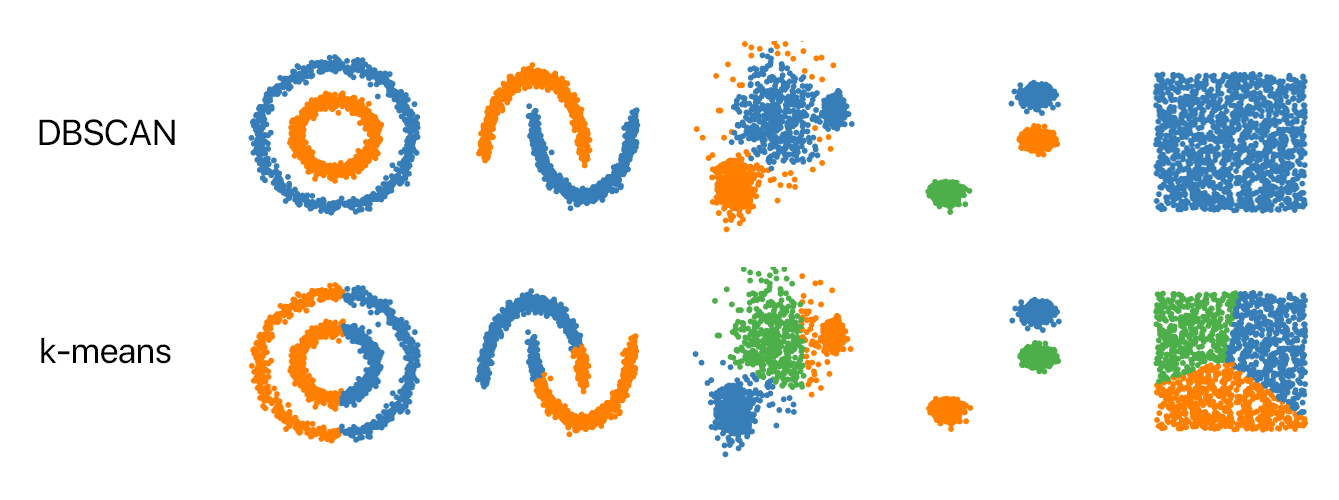

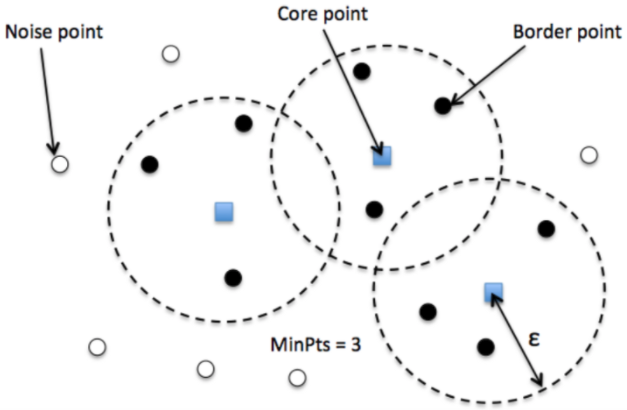

* Core Object- If the ε-neighborhood of an object contains at least minpts objects, then the object is a core object

* A border point has fewer than minpt within ε, but is in the neighborhood of a core point

* A noise point is any point that is not a core point nor a border point

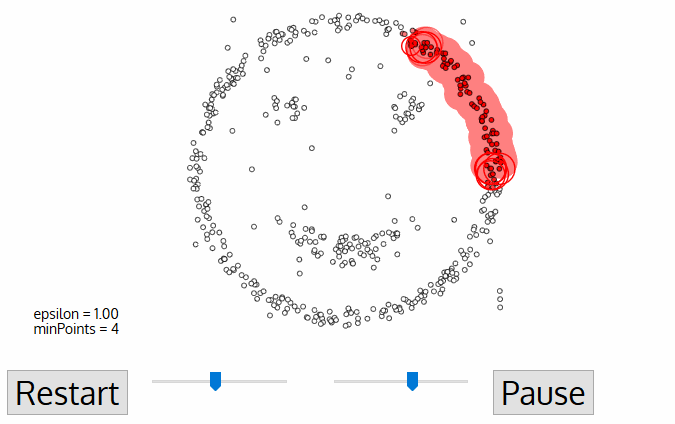

# Installing and importing packages

In [ ]:
!pip install kneed
!pip install hdbscan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import hdbscan
import kneed
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings(action='ignore')

# *Exploratory data analysis*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [ ]:
data.shape

(284807, 31)

In [ ]:
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [ ]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

This dataset is exceptionally clean, with no missing values and exclusively numerical variables.

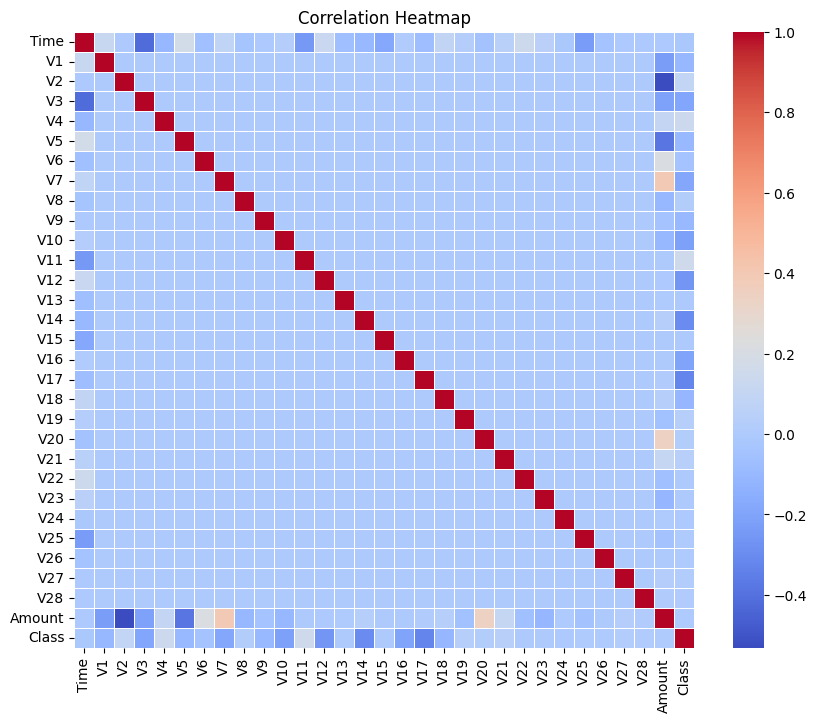

In [ ]:
#correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Correlation Heatmap')
plt.show()

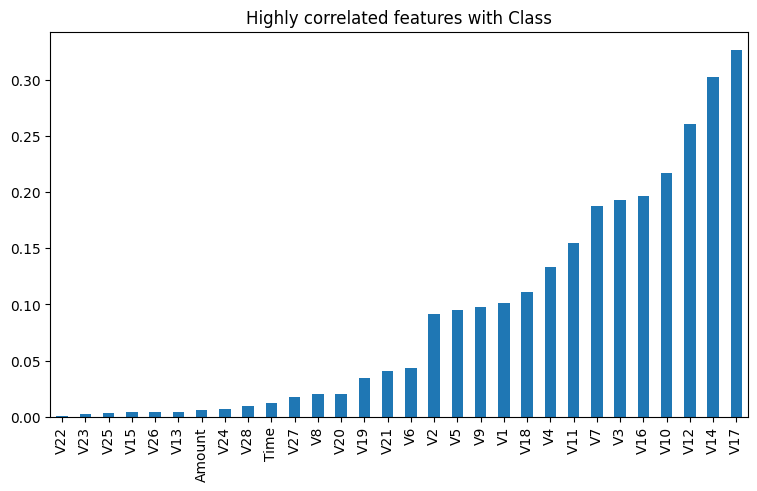

In [ ]:
plt.figure(figsize=(9,5))
d = data.corr()['Class'][:-1].abs().sort_values().plot(kind='bar', title='Highly correlated features with Class')

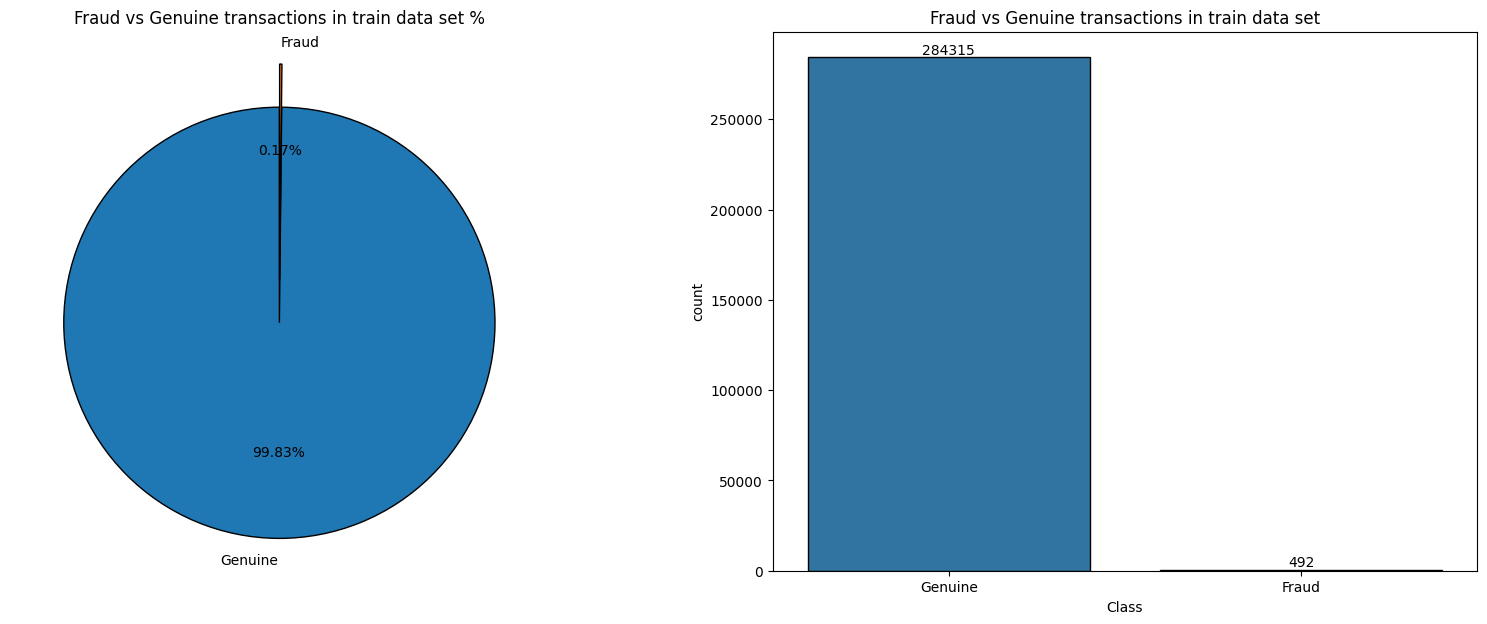

In [ ]:
l1 = list(data['Class'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['Genuine','Fraud'],
        autopct = '%1.2f%%',
        startangle = 90,
        explode = (0.1,0.1),
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Fraud vs Genuine transactions in train data set %');

plt.subplot(1,2,2)
ax = sns.countplot(data = data,
                   x='Class',
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])

plt.title('Fraud vs Genuine transactions in train data set')
plt.show()


We have 99,83% of Genuine transactions (284315) and only 0,17% (492) of fraud transactions!

This means that a blind guess (bet on Genuine) would give us accuracy of 99,8%.

In [ ]:
print('Number of duplicated values in dataset: ', data.duplicated().sum())

Number of duplicated values in dataset:  1081


In [ ]:
data.drop_duplicates(inplace=True)
print('The amount of frauds in data after dropping duplicates: ', len(data[data['Class'] == 1]))

The amount of frauds in data after dropping duplicates:  473


## Visualizing


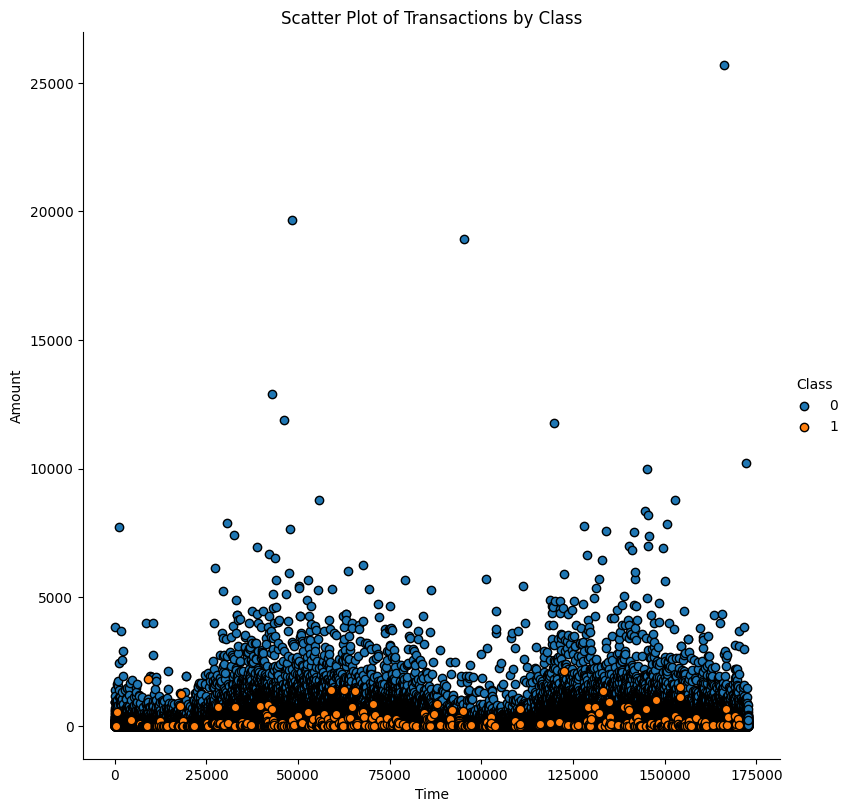

In [ ]:
grid = sns.FacetGrid(data, hue="Class", height =8)
grid.map(plt.scatter, "Time", "Amount", edgecolor="k").add_legend()

plt.title('Scatter Plot of Transactions by Class')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

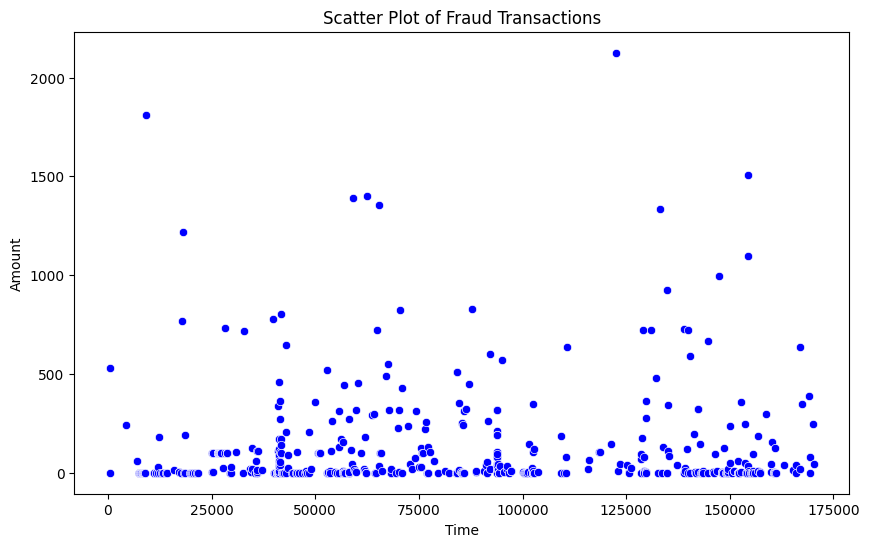

In [ ]:
fraud_data = data[data['Class'] == 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', data=fraud_data, color='blue')
plt.title('Scatter Plot of Fraud Transactions')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

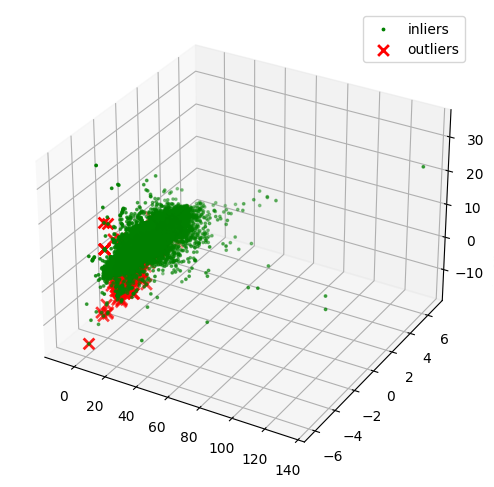

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  #Considered only 3 components to put into 3 dimensions
to_model_cols = data.columns[0:30]
outliers = data.loc[data['Class']==1]
outlier_index=list(outliers.index)
scaler = StandardScaler()
X = scaler.fit_transform(data[to_model_cols])
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3_using_PCA")
# Plotting compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=3, lw=1, label="inliers",c="green")
# Plot x for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           s=60, lw=2, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

# Balancing data

In [ ]:
fraud_data = data[data['Class'] == 1]
not_fraud_data = data[data['Class'] == 0]
fraud_size = 473

# Randomly sample a subset of fraud data
fraud_data_sampled = fraud_data.sample(n=fraud_size, random_state=42)

nonfraud_size = 10000
# Randomly sample a subset of not fraud data
not_fraud_data_sampled = not_fraud_data.sample(n=nonfraud_size, random_state=42)

# Concatenate fraud and sampled not fraud data to create a partially balanced dataset
balanced_df = pd.concat([fraud_data_sampled, not_fraud_data_sampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
data = balanced_df

In [ ]:
X = data.drop('Class', axis=1)
y = data['Class']

# Applying SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Creating a new dataframe with the balanced data
balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
balanced_data['Class'] = y_resampled

X_balanced = balanced_data.drop('Class', axis=1)
y_balanced = balanced_data['Class']

In [ ]:
print("Data Class Distribution:")
print(y.value_counts())
print("Balanced_data Class Distribution:")
print(y_balanced.value_counts())

Data Class Distribution:
0    10000
1      473
Name: Class, dtype: int64
Balanced_data Class Distribution:
0    10000
1    10000
Name: Class, dtype: int64


## Scalling

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_balanced = scaler.fit_transform(X_balanced)

# Distance plot and eps value

In [ ]:
min_samples = 2*(X.shape[1])
min_samples

60

In [ ]:
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

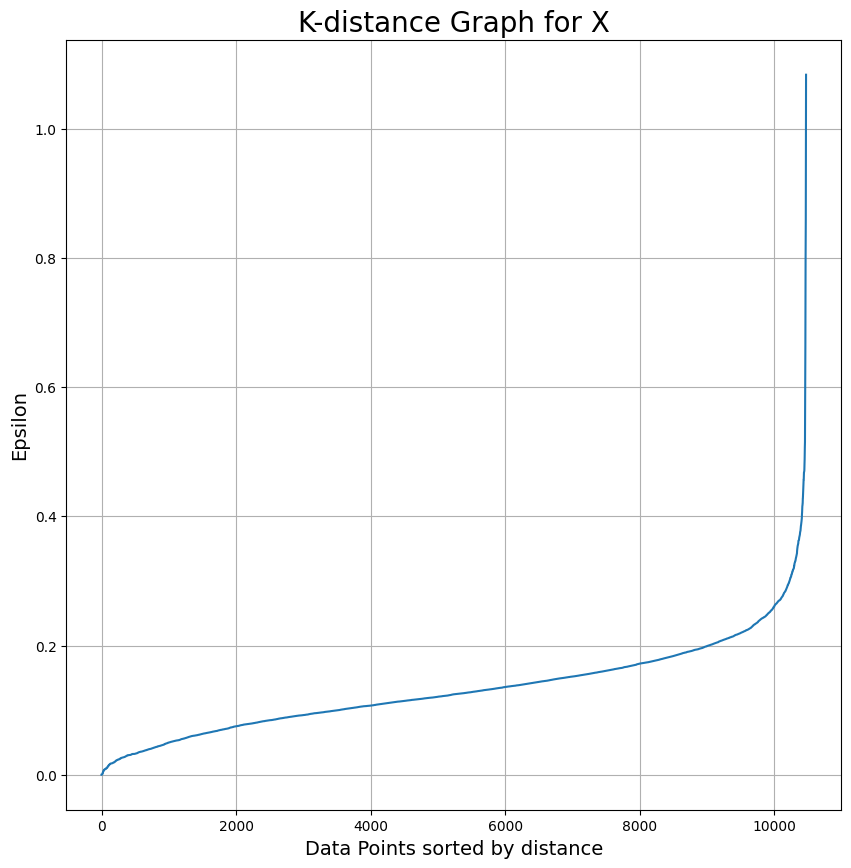

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(10,10))
plt.title('K-distance Graph for X',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.grid(True)
plt.plot(distances)
plt.show()

Visually, we have an optimal value for eps at 0.2 <= eps <= 0.4. However, let's use the Kneed package to define the inflection point without needing to estimate it by eye:

In [ ]:
kneedle=kneed.KneeLocator(y=distances,x=np.arange(0, X_scaled.shape[0]), S=1.0, curve='convex', direction='increasing')
inflection_point=[kneedle.knee, kneedle.knee_y]
inflection_point

[10365, 0.3628880496111683]

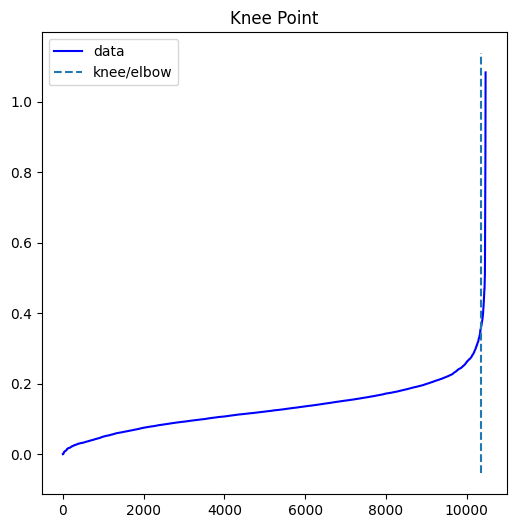

In [ ]:
kneedle.plot_knee()

In [ ]:
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_balanced)
distances, indices = neighbors_fit.kneighbors(X_balanced)

# Using KneeLocator to find the inflection point
kneedle = kneed.KneeLocator(y=distances[:, 1], x=np.arange(0, X_balanced.shape[0]), S=1.0, curve='convex', direction='increasing')
inflection_point2 = [kneedle.knee, kneedle.knee_y]
inflection_point2

[19999, 0.005772060513995191]

# *Models*

## *Creating model for balanced_data*

In [ ]:
dbscan = DBSCAN(eps=inflection_point2[1], min_samples=min_samples).fit(X_balanced)
balanced_data['dbscan_labels'] = dbscan.labels_
balanced_data['binary_labels'] = np.where(balanced_data['dbscan_labels'] == -1, 1, 0)
balanced_data['binary_labels'].value_counts()

1    19819
0      181
Name: binary_labels, dtype: int64

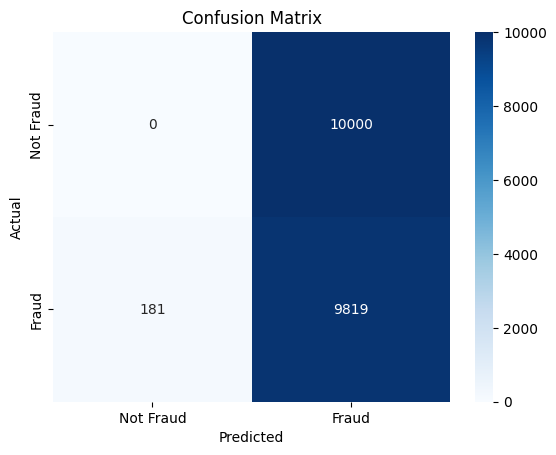

In [ ]:
sns.heatmap(confusion_matrix(y_balanced, balanced_data['binary_labels']), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Accuracy Score:", accuracy_score(y_balanced, balanced_data['binary_labels']))
print("AUC-ROC Score:", roc_auc_score(y_balanced, balanced_data['binary_labels']))
print("Recall Score:", recall_score(y_balanced, balanced_data['binary_labels']))
print("Precision Score:", precision_score(y_balanced, balanced_data['binary_labels']))
print("F1 Score:", f1_score(y_balanced, balanced_data['binary_labels']))

Accuracy Score: 0.49095
AUC-ROC Score: 0.49095
Recall Score: 0.9819
Precision Score: 0.49543367475654676
F1 Score: 0.6585733928032462


## Creating model for *data*

In [ ]:
dbscan = DBSCAN(eps=inflection_point[1], min_samples=min_samples).fit(X_scaled)
data['dbscan_labels'] = dbscan.labels_
data['binary_labels'] = np.where(data['dbscan_labels'] == -1, 1, 0)
data['binary_labels'].value_counts()

0    9999
1     474
Name: binary_labels, dtype: int64

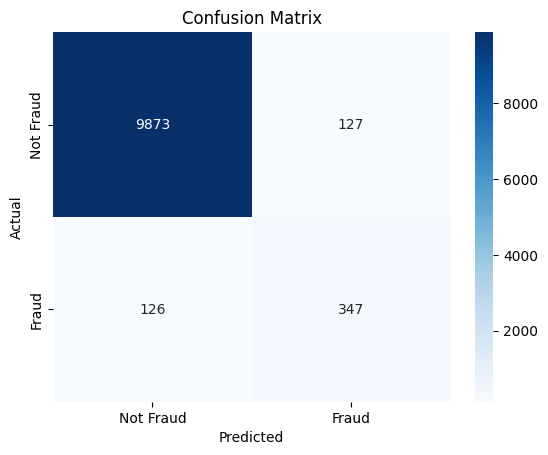

In [ ]:
sns.heatmap(confusion_matrix(y, data['binary_labels']), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Accuracy Score:", accuracy_score(y, data['binary_labels']))
print("AUC-ROC Score:", roc_auc_score(y, data['binary_labels']))
print("Recall Score:", recall_score(y, data['binary_labels']))
print("Precision Score:", precision_score(y, data['binary_labels']))
print("F1 Score:", f1_score(y, data['binary_labels']))

Accuracy Score: 0.9758426429867277
AUC-ROC Score: 0.8604576109936576
Recall Score: 0.733615221987315
Precision Score: 0.7320675105485233
F1 Score: 0.7328405491024288


## *Finding an optimal value for eps*

In [ ]:
values_list = np.arange(0.3, 0.4, 0.01)
max_f1 = 0
best_eps = 0

for eps_value in values_list:
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
    dbscan.fit(X_scaled)
    data['dbscan_labels'] = dbscan.labels_

    # Create binary labels based on the DBSCAN labels
    data['binary_labels'] = np.where(data['dbscan_labels'] == -1, 1, 0)
    f1 = f1_score(y, data['binary_labels'])
    print(f"F1-Score: {f1}, eps {eps_value}")

    if f1 > max_f1:
        max_f1 = f1
        best_eps = eps_value

print(f"Best Eps: {best_eps}, Max F1-Score: {max_f1}")

F1-Score: 0.6369327073552425, eps 0.3
F1-Score: 0.6837169650468883, eps 0.31
F1-Score: 0.7064056939501779, eps 0.32
F1-Score: 0.71875, eps 0.33
F1-Score: 0.7404580152671756, eps 0.34
F1-Score: 0.7490196078431373, eps 0.35000000000000003
F1-Score: 0.7400611620795107, eps 0.36000000000000004
F1-Score: 0.7429171038824764, eps 0.37000000000000005
F1-Score: 0.7117903930131005, eps 0.38000000000000006
F1-Score: 0.7064116985376828, eps 0.39000000000000007
F1-Score: 0.7066974595842956, eps 0.4000000000000001
Best Eps: 0.35000000000000003, Max F1-Score: 0.7490196078431373


## *Evaluating the model*

In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples).fit(X_scaled)
data['dbscan_labels'] = dbscan.labels_
data['binary_labels'] = np.where(data['dbscan_labels'] == -1, 1, 0)
data['binary_labels'].value_counts()

0    9926
1     547
Name: binary_labels, dtype: int64

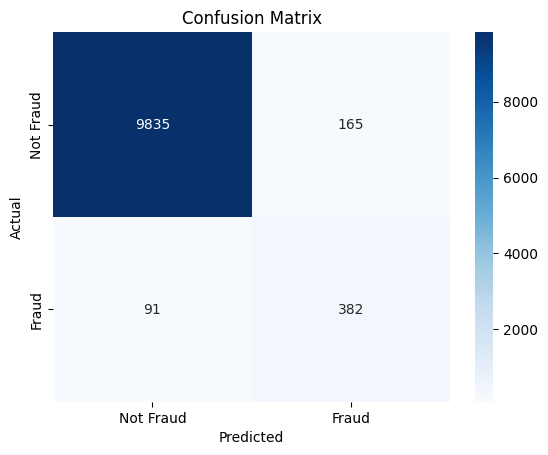

In [ ]:
sns.heatmap(confusion_matrix(y, data['binary_labels']), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision = precision_score(y, data['binary_labels'])
recall = recall_score(y, data['binary_labels'])
f1 = f1_score(y, data['binary_labels'])
accuracy = accuracy_score(y, data['binary_labels'])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.7073170731707317
Recall: 0.7970401691331924
F1-score: 0.7495029821073559
Accuracy: 0.9759381266112862


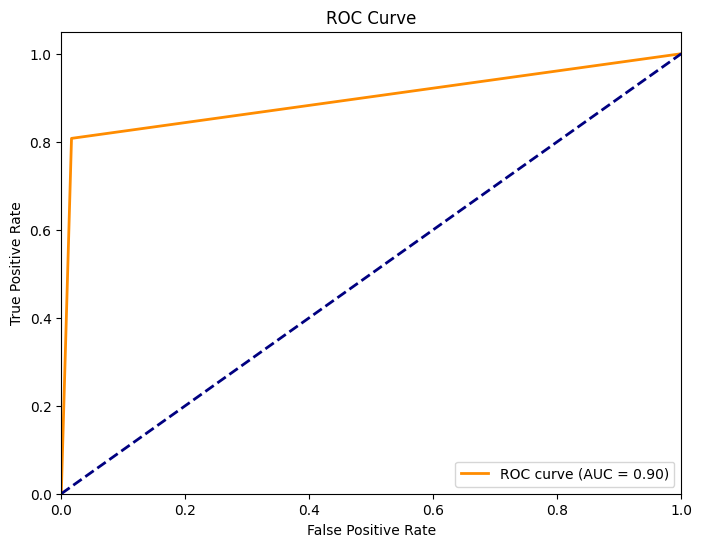

In [ ]:
fpr, tpr, _ = roc_curve(y, data["binary_labels"])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

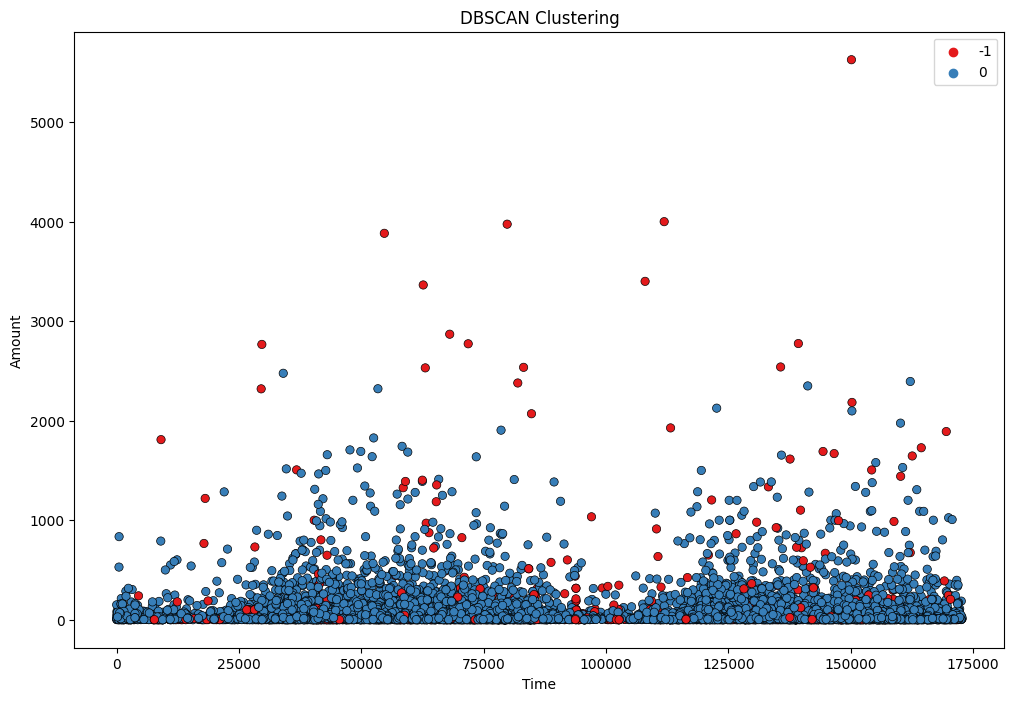

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Time', y='Amount', hue=dbscan.labels_, data=data, palette='Set1', edgecolor='k', legend='full')
plt.title('DBSCAN Clustering')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

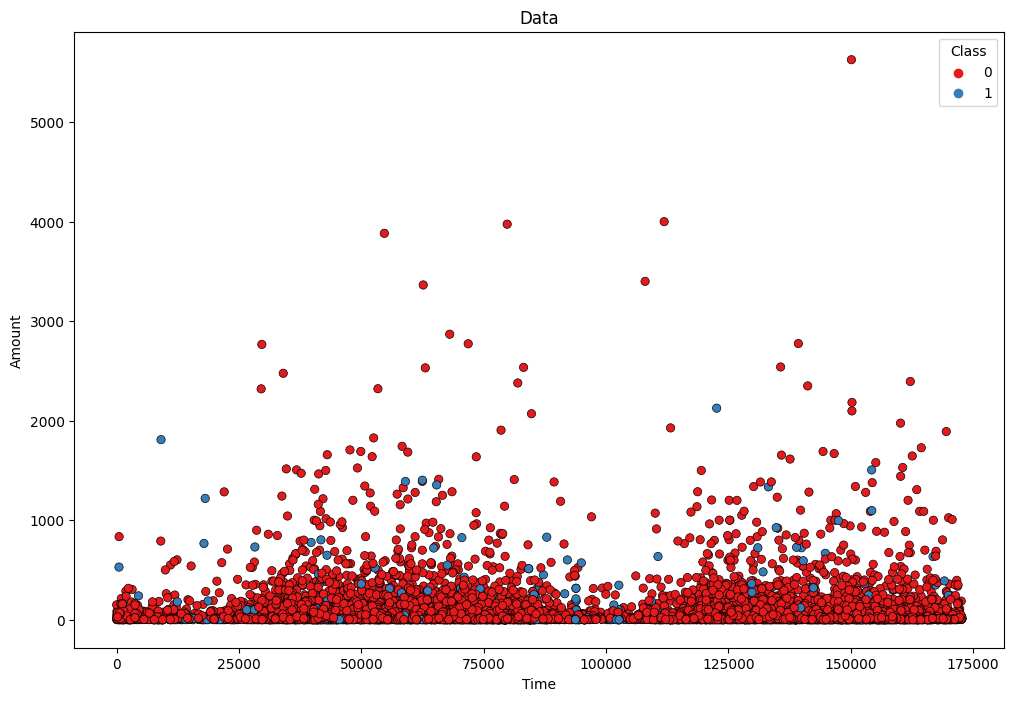

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Time', y='Amount', hue=y, palette='Set1', data=data, edgecolor='k', legend='full')
plt.title('Data')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

## *HDBSCAN*


Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) is a clustering algorithm that extends the capabilities of DBSCAN by introducing a hierarchical approach. It not only identifies clusters in data but also forms a hierarchy, allowing for the detection of clusters at multiple density levels. This hierarchical perspective enhances the robustness of density-based clustering, making HDBSCAN particularly effective in revealing structures in datasets with varying levels of density.

### *Selecting min_cluster_size and min_samples*


The primary parameter to effect the resulting clustering is min_cluster_size. Ideally this is a relatively intuitive parameter to select – set it to the smallest size grouping that you wish to consider a cluster. It can have slightly non-obvious effects however. Let’s consider the digits dataset from sklearn. We can project the data into two dimensions to visualize it via t-SNE.

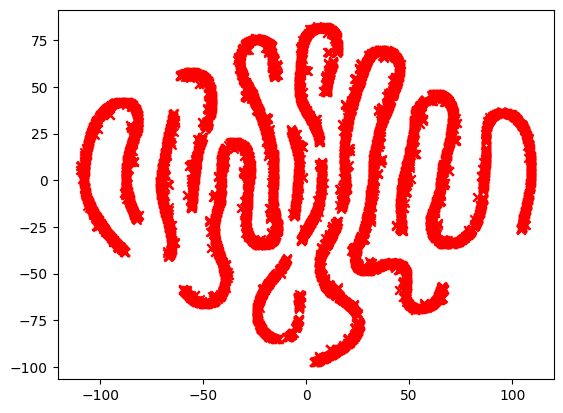

In [ ]:
plot_kwds = {'c': 'red', 'marker': 'x', 'label': 'Points'}
projection = TSNE().fit_transform(data)
plt.scatter(*projection.T, **plot_kwds)

We start with a min_cluster_size of 10.

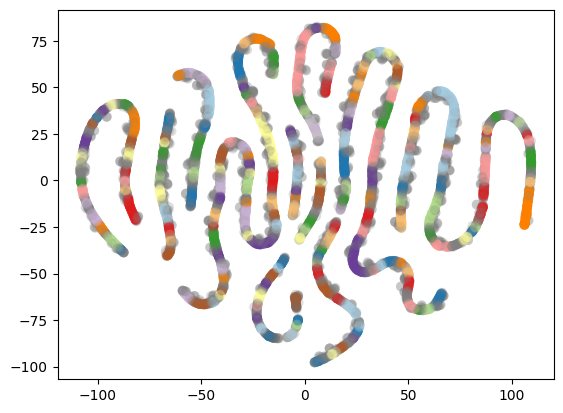

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(data)
color_palette = sns.color_palette('Paired', 12)

cluster_colors = [color_palette[x % len(color_palette)] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)


Increasing the min_cluster_size to 30 reduces the number of clusters, merging some together.

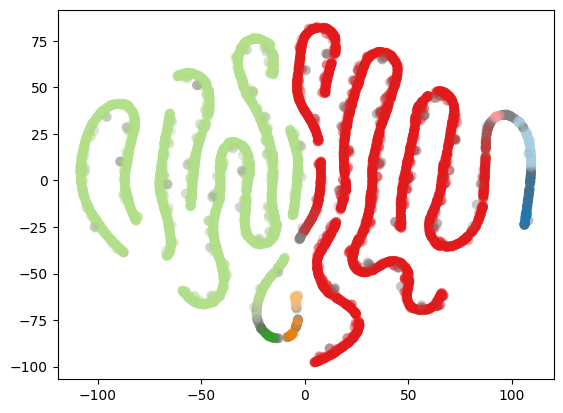

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30).fit(data)
color_palette = sns.color_palette('Paired', 12)

cluster_colors = [color_palette[x % len(color_palette)] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)


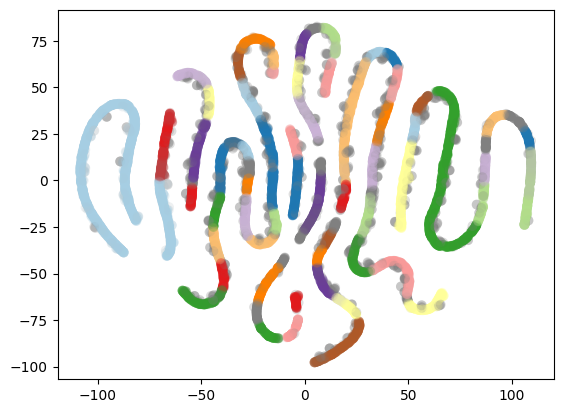

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=1).fit(data)
color_palette = sns.color_palette('Paired', 12)

# Ensure that the cluster labels are within the range of the color_palette
max_label = max(clusterer.labels_)
cluster_colors = [color_palette[x % len(color_palette)] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()

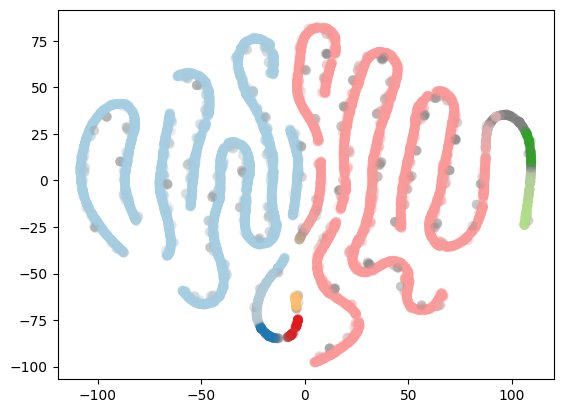

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=15).fit(data)
color_palette = sns.color_palette('Paired', 12)

max_label = max(clusterer.labels_)
cluster_colors = [color_palette[x % len(color_palette)] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()

### *HDBSCAN for data*

In [ ]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=15)
hdbscan_model.fit(X_scaled)
data['hdbscan_labels'] = hdbscan_model.labels_
data['binary_labels'] = np.where(data['hdbscan_labels'] == -1, 1, 0)

precision = precision_score(y, data['binary_labels'])
recall = recall_score(y, data['binary_labels'])
accuracy = accuracy_score(y, data['binary_labels'])
f1 = f1_score(data['Class'], data['binary_labels'])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.6229508196721312
Recall: 0.080338266384778
F1-score: 0.14232209737827714
Accuracy: 0.9562684999522582


In [ ]:
min_cluster_sizes = range(5, 15, 3)
min_samples_values = range(30, 50, 5)

max_f1_score = 0
best_min_cluster_size = 0
best_min_samples = 0

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, allow_single_cluster=True)
        hdbscan_model.fit(X_scaled)
        data['hdbscan_labels'] = hdbscan_model.labels_

        # Create binary labels based on the HDBSCAN labels
        data['binary_labels'] = np.where(data['hdbscan_labels'] == -1, 1, 0)

        f1 = f1_score(data['Class'], data['binary_labels'])
        print(f"Min Cluster Size: {min_cluster_size}, Min Samples: {min_samples}, F1-Score: {f1}")

        # Update maximum F1-score and corresponding parameters if needed
        if f1 > max_f1_score:
            max_f1_score = f1
            best_min_cluster_size = min_cluster_size
            best_min_samples = min_samples

print(f"Best Min Cluster Size: {best_min_cluster_size}, Best Min Samples: {best_min_samples}")
print(f"Max F1-Score: {max_f1_score}")

Min Cluster Size: 5, Min Samples: 30, F1-Score: 0.24057450628366245
Min Cluster Size: 5, Min Samples: 35, F1-Score: 0.2921739130434783
Min Cluster Size: 5, Min Samples: 40, F1-Score: 0.31560891938250424
Min Cluster Size: 5, Min Samples: 45, F1-Score: 0.37623762376237624
Min Cluster Size: 8, Min Samples: 30, F1-Score: 0.25932504440497334
Min Cluster Size: 8, Min Samples: 35, F1-Score: 0.2921739130434783
Min Cluster Size: 8, Min Samples: 40, F1-Score: 0.3299319727891157
Min Cluster Size: 8, Min Samples: 45, F1-Score: 0.38952536824877254
Min Cluster Size: 11, Min Samples: 30, F1-Score: 0.25932504440497334
Min Cluster Size: 11, Min Samples: 35, F1-Score: 0.2921739130434783
Min Cluster Size: 11, Min Samples: 40, F1-Score: 0.3299319727891157
Min Cluster Size: 11, Min Samples: 45, F1-Score: 0.11610813504422575
Min Cluster Size: 14, Min Samples: 30, F1-Score: 0.25932504440497334
Min Cluster Size: 14, Min Samples: 35, F1-Score: 0.2921739130434783
Min Cluster Size: 14, Min Samples: 40, F1-Score:

Best Min Cluster Size: 8, Best Min Samples: 45
Max F1-Score: 0.38952536824877254

In [ ]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples, allow_single_cluster=True)
hdbscan_model.fit(X_scaled)
data['hdbscan_labels'] = hdbscan_model.labels_
data['binary_labels'] = np.where(data['hdbscan_labels'] == -1, 1, 0)

precision = precision_score(y, data['binary_labels'])
recall = recall_score(y, data['binary_labels'])
accuracy = accuracy_score(y, data['binary_labels'])
f1 = f1_score(data['Class'], data['binary_labels'])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.8623188405797102
Recall: 0.25158562367864695
F1-score: 0.38952536824877254
Accuracy: 0.9643846080397211


### HDBSCAN for balanced data

In [ ]:
min_cluster_sizes = range(5, 20, 4)
min_samples_values = range(20, 35,  3)

max_f1_score = 0
best_min_cluster_size = 0
best_min_samples = 0

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        hdbscan_model.fit(X_balanced)
        balanced_data['hdbscan_labels'] = hdbscan_model.labels_

        # Create binary labels based on the HDBSCAN labels
        balanced_data['binary_labels'] = np.where(balanced_data['hdbscan_labels'] == -1, 1, 0)

        f1 = f1_score(balanced_data['Class'], balanced_data['binary_labels'])
        print(f"Min Cluster Size: {min_cluster_size}, Min Samples: {min_samples}, F1-Score: {f1}")

        # Update maximum F1-score and corresponding parameters if needed
        if f1 > max_f1_score:
            max_f1_score = f1
            best_min_cluster_size = min_cluster_size
            best_min_samples = min_samples

print(f"Best Min Cluster Size: {best_min_cluster_size}, Best Min Samples: {best_min_samples}")
print(f"Max F1-Score: {max_f1_score}")

Min Cluster Size: 5, Min Samples: 20, F1-Score: 0.42354941551540914
Min Cluster Size: 5, Min Samples: 23, F1-Score: 0.44855012427506213
Min Cluster Size: 5, Min Samples: 26, F1-Score: 0.4701415542074202
Min Cluster Size: 5, Min Samples: 29, F1-Score: 0.48092209856915735
Min Cluster Size: 5, Min Samples: 32, F1-Score: 0.4911912073702926
Min Cluster Size: 9, Min Samples: 20, F1-Score: 0.42611683848797255
Min Cluster Size: 9, Min Samples: 23, F1-Score: 0.4547496256862419
Min Cluster Size: 9, Min Samples: 26, F1-Score: 0.46805040166374423
Min Cluster Size: 9, Min Samples: 29, F1-Score: 0.47530988815762903
Min Cluster Size: 9, Min Samples: 32, F1-Score: 0.4915476776628918
Min Cluster Size: 13, Min Samples: 20, F1-Score: 0.418662227344517
Min Cluster Size: 13, Min Samples: 23, F1-Score: 0.4524256455178743
Min Cluster Size: 13, Min Samples: 26, F1-Score: 0.4674011345885061
Min Cluster Size: 13, Min Samples: 29, F1-Score: 0.48749896856176256
Min Cluster Size: 13, Min Samples: 32, F1-Score: 0.4

In [ ]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size, min_samples=best_min_samples, gen_min_span_tree=True)
hdbscan_model.fit(X_balanced)
balanced_data['hdbscan_labels'] = hdbscan_model.labels_
balanced_data['binary_labels'] = np.where(balanced_data['hdbscan_labels'] == -1, 1, 0)

precision = precision_score(y_balanced, balanced_data['binary_labels'])
recall = recall_score(y_balanced, balanced_data['binary_labels'])
accuracy = accuracy_score(y_balanced, balanced_data['binary_labels'])
f1 = f1_score(y_balanced, balanced_data['binary_labels'])

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.41678263289730033
Recall: 0.599
F1-score: 0.4915476776628918
Accuracy: 0.3804


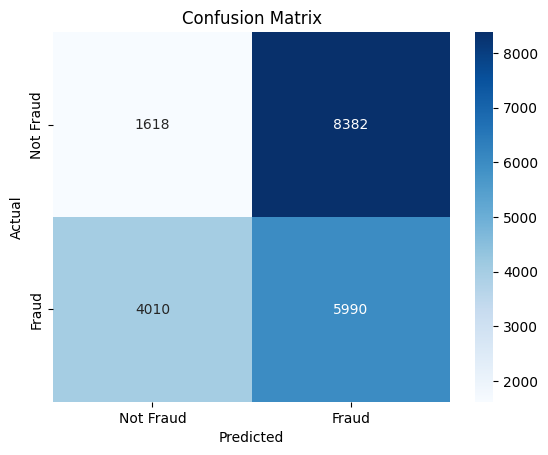

In [ ]:
sns.heatmap(confusion_matrix(y_balanced, balanced_data['binary_labels']), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

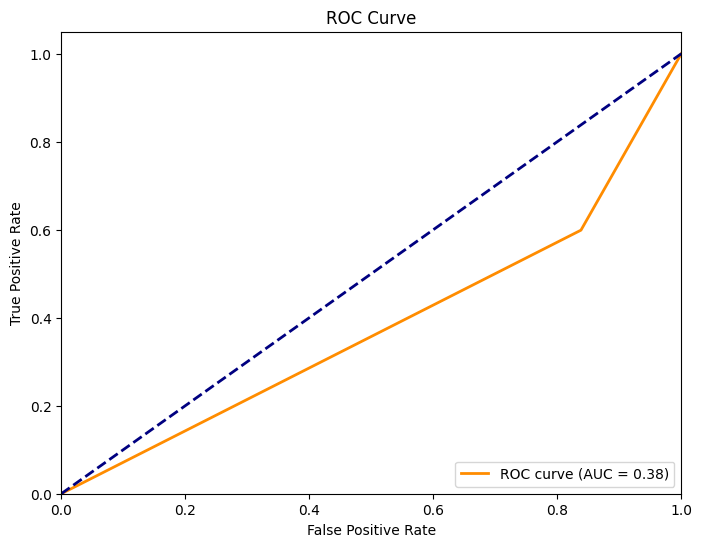

In [ ]:
fpr, tpr, _ = roc_curve(y_balanced, balanced_data["binary_labels"])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Conclusion

In summary, my project aimed to improve fraud detection using clustering algorithms, specifically HDBSCAN and DBSCAN. After thorough testing, we found that the DBSCAN model demonstrated higher accuracy in identifying fraudulent patterns within our dataset. This outcome underscores the importance of choosing clustering algorithms tailored to the unique characteristics of the data and project objectives.